In [1]:
from matplotlib import pyplot as plt
# from astropy.utils.data import download_file
# from astropy.time import Time, TimeDelta
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
# import xml.etree.ElementTree as ET, gzip, io

from dateutil.parser import parse as date_parse
import numpy as np

from collections import namedtuple
from glob import glob
from astropy.io import fits

from tqdm import tqdm_notebook

# from piaa import exoplanets
import exodata

In [2]:
Transit = namedtuple('Transit', ['ingress', 'midpoint', 'egress'])

In [3]:
# Load our list of stored images
fn = '/var/panoptes/wasp43.txt'

fits_fn = !cat $fn | grep -v 'pointing' | grep 'Wasp43'

In [4]:
# Load the exoplanet catalogue
exocat = exodata.load_db_from_url()

In [5]:
# Get the names of the fields we've observed
observed_planets = set([f.split('/')[4] for f in fits_fn])

In [6]:
# Search observed fields for matching planet in catalogue
transit_planets = {p:exocat.searchPlanet(p) for p in observed_planets}

In [7]:
def in_transit(planet, t1, with_times=False):
    if isinstance(t1, str):
        t1 = Time(t1)

    transittime = Time(planet.transittime, format='jd')
    transit_duration = planet.calcTransitDuration(circular=True).item() * u.minute
    planet_period = planet.calcPeriod().item() * u.day
    period_delta = TimeDelta(planet_period.to(u.s), format='sec')

    num_periods = int((t1 - transittime).sec // period_delta.sec)
    in_transit = False

    for n in range(num_periods, num_periods + 2):
        midpoint = transittime + (n * period_delta)
        ingress = midpoint - (transit_duration / 2)
        egress = midpoint + (transit_duration / 2)

        in_transit = t1 >= ingress and t1 <= egress

        if in_transit:
            break

    if with_times:
        return (in_transit, Transit(ingress, midpoint, egress))
    else:
        return in_transit

In [8]:
transits = dict()
for fn in tqdm_notebook(fits_fn):
    if 'pointing' in fn:
        continue 
    
    try:
        _, _, _, unit_id, field, cam_id, seq_id, img_id = fn.split('/')
    except ValueError:
        continue 
        
    img_id = img_id.split('.')[0]
    
    if seq_id in transits:
        continue
    
    try:
        planet = transit_planets[field]
    except KeyError:
        continue
        
    try:
        tt0 = Time(date_parse(img_id), format='datetime')
    except Exception as e:
#         print(img_id, e)
        continue
    
    try:
        in_t = in_transit(planet, tt0, with_times=True)
    except Exception as e:
        continue
#         print(e)
#         print(planet, tt0)
    else:
        if in_t[0]:
            transits[seq_id] = {'transit': in_t[1], 'planet': planet}

In [9]:
def get_phase(planet, t):
    period = planet.calcPeriod().item()
    phase = ((t.mjd - Time(planet.transittime, format='jd').mjd) % period) / period
    if phase >= 0.5:
        phase -= 1.0
        
    return phase

In [13]:
phase = np.array([(i, get_phase(p, Time(date_parse(fn.split('/')[7].split('.')[0]), format='datetime'))) for i, fn in enumerate(fits_fn)])

([], <a list of 0 Text yticklabel objects>)

/home/wtylergee/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


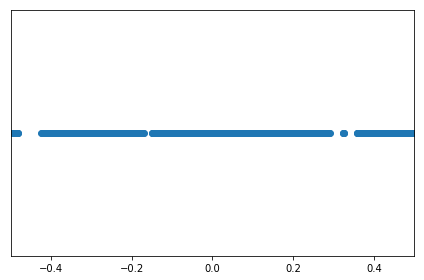

In [14]:
# Three subplots sharing both x/y axes

# for i, fn in enumerate(fits_fn):
#     image_time = fn.split('/')[7].split('.')[0]
    
#     date_obs = 
        
#     ax.plot([get_phase(p, t.ingress), 0], [0.5, 0.5], color='r', label='Transit')
#     ax.plot([0, get_phase(p, t.egress)], [0.5, 0.5], color='r')
#     ax.scatter(get_phase(p, date_obs), 0.6, color='b', label='Observation')

plt.scatter(phase[:, 1], np.ones_like(phase[:, 1]))
# ax.legend()

# ax.set_title("{} {} {:.02f} {}".format(p.name, seq_id, p.calcTransitDepth().item(), p.system.stars[0].magV))
plt.xlim(-0.5, 0.5)
plt.ylim(0.9, 1.1)
plt.yticks([])

/home/wtylergee/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


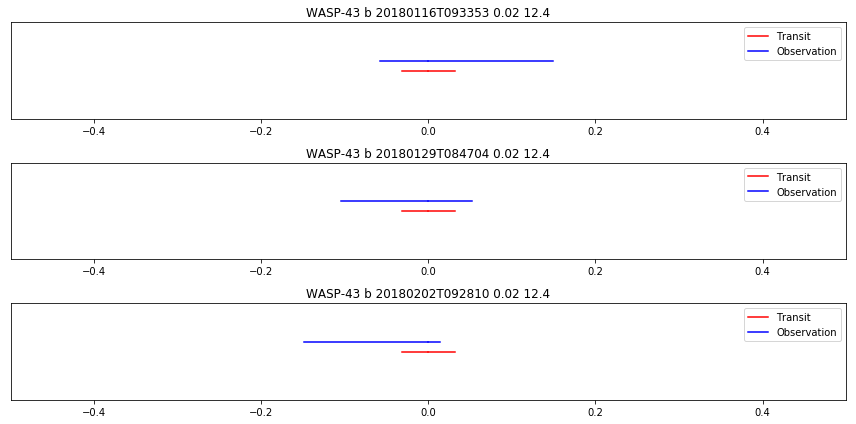

In [12]:
# Three subplots sharing both x/y axes

f, axes = plt.subplots(len(transits), sharey=True)
f.set_size_inches(12, 2 * len(transits))

for i, seq_id in enumerate(transits.keys()):
    ax = axes[i]
    
    t = transits[seq_id]['transit']
    p = transits[seq_id]['planet']
    
    image_times = sorted(set(([x.split('/')[7].split('.')[0] for x in fits_fn if seq_id in x])))
    
    start_obs = Time(date_parse(image_times[0]), format='datetime')
    end_obs = Time(date_parse(image_times[-1]), format='datetime')
    
    if isinstance(p, list):
        p = p[0]
    
    ax.plot([get_phase(p, t.ingress), 0], [0.5, 0.5], color='r', label='Transit')
    ax.plot([0, get_phase(p, t.egress)], [0.5, 0.5], color='r')
    ax.plot([get_phase(p, start_obs), 0], [0.6, 0.6], color='b', label='Observation')
    ax.plot([0, get_phase(p, end_obs)], [0.6, 0.6], color='b')
    ax.legend()
    
    ax.set_title("{} {} {:.02f} {}".format(p.name, seq_id, p.calcTransitDepth().item(), p.system.stars[0].magV))
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(0, 1)
    ax.get_yaxis().set_ticks([])

    f.subplots_adjust(hspace=0)
#     f.autofmt_xdate()
    
#     plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

In [38]:
list(transits.keys())

['20180116T093353', '20180129T084704', '20180202T092810']